In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

2023-12-18 19:04:22.001587: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 19:04:22.119272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 19:04:22.119310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 19:04:22.139153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 19:04:22.180570: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define your data directories
train_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Train'
test_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Test'
validation_dir = 'Original and counterfeit Colombian peso banknotes/COP_banknote/ds1/Validation'

In [3]:
# Common Hyperparameters
batch_size = 32
num_epochs = 3
num_classes = 12
learning_rate = 0.001

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
# Define a function to build and train a model
def build_and_train_model(base_model, model_name, train_dir, validation_dir, test_dir, input_shape):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)  # Adding dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers from the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Training {model_name}...")

    train_generator = create_data_generator(train_dir, train_datagen, input_shape)
    validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), input_shape)
    test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), input_shape)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=num_epochs
    )

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
    print(f"{model_name} Test accuracy: {test_acc * 100:.2f}%")

    return model, test_generator, history

In [6]:
def create_data_generator(data_dir, data_generator, input_shape):
    return data_generator.flow_from_directory(
        data_dir,
        target_size=input_shape,
        batch_size=batch_size,
        class_mode='categorical',
        classes=['100k', '100kf', '10k', '10kf', '50k', '50kf', '5k', '5kf', '20k', '20kf', '2k', '2kf']
    )

In [7]:
# Load the pre-trained VGG16 model weights
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
vgg16_x = vgg16_base_model.output
vgg16_x = GlobalAveragePooling2D()(vgg16_x)
vgg16_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(vgg16_x)
vgg16_x = Dropout(0.5)(vgg16_x)  # Adding dropout for regularization
vgg16_predictions = Dense(num_classes, activation='softmax')(vgg16_x)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_predictions)

# Freeze the layers from the base model
for layer in vgg16_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
vgg16_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training VGG16...")
vgg16_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
vgg16_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

vgg16_history = vgg16_model.fit(
  vgg16_train_generator,
  steps_per_epoch= len(vgg16_train_generator),
  validation_data=vgg16_validation_generator,
  validation_steps=len(vgg16_validation_generator),
  epochs=num_epochs
)

# Evaluate the performance of VGG16 on the original and counterfeit banknote detection tasks
vgg16_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(vgg16_test_generator, steps=len(vgg16_test_generator))
print(f"VGG16 Test accuracy: {vgg16_test_acc * 100:.2f}%")

2023-12-18 19:04:23.904132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 19:04:23.971048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 19:04:23.971197: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Training VGG16...
Found 10658 images belonging to 12 classes.
Found 3598 images belonging to 12 classes.
Epoch 1/3


2023-12-18 19:04:25.275137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-18 19:04:25.370301: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-18 19:04:25.974112: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  1/334 [..............................] - ETA: 9:28 - loss: 9.4932 - accuracy: 0.0312

2023-12-18 19:04:26.285408: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8c8dafb110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-18 19:04:26.285422: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-18 19:04:26.291264: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702906466.337340    7333 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


334/334 [==============================] - 49s 142ms/step - loss: 693909143420928.0000 - accuracy: 0.2460 - val_loss: 2.0664 - val_accuracy: 0.3513
Epoch 2/3
334/334 [==============================] - 45s 134ms/step - loss: 2.1075 - accuracy: 0.3111 - val_loss: 2.0085 - val_accuracy: 0.3471
Epoch 3/3
334/334 [==============================] - 44s 133ms/step - loss: 2.0448 - accuracy: 0.3243 - val_loss: 1.9075 - val_accuracy: 0.3638
Found 3600 images belonging to 12 classes.
113/113 [==============================] - 5s 44ms/step - loss: 1.9091 - accuracy: 0.3744
VGG16 Test accuracy: 37.44%


In [8]:
# Load the pre-trained ResNet50 model weights
resnet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
resnet50_x = resnet50_base_model.output
resnet50_x = GlobalAveragePooling2D()(resnet50_x)
resnet50_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(resnet50_x)
resnet50_x = Dropout(0.5)(resnet50_x)  # Adding dropout for regularization
resnet50_predictions = Dense(num_classes, activation='softmax')(resnet50_x)
resnet50_model = Model(inputs=resnet50_base_model.input, outputs=resnet50_predictions)

# Freeze the layers from the base model
for layer in resnet50_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
resnet50_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training ResNet50...")
resnet50_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
resnet50_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

resnet50_history = resnet50_model.fit(
    resnet50_train_generator,
    steps_per_epoch=len(resnet50_train_generator),
    validation_data=resnet50_validation_generator,
    validation_steps=len(resnet50_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of ResNet50 on the original and counterfeit banknote detection tasks
resnet50_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(resnet50_test_generator, steps=len(resnet50_test_generator))
print(f"ResNet50 Test accuracy: {resnet50_test_acc * 100:.2f}%")

Training ResNet50...
Found 10658 images belonging to 12 classes.
Found 3598 images belonging to 12 classes.
Epoch 1/3
334/334 [==============================] - 47s 135ms/step - loss: 3.1512 - accuracy: 0.1401 - val_loss: 2.2966 - val_accuracy: 0.1834
Epoch 2/3
334/334 [==============================] - 45s 135ms/step - loss: 2.1804 - accuracy: 0.1670 - val_loss: 2.0796 - val_accuracy: 0.1868
Epoch 3/3
334/334 [==============================] - 45s 134ms/step - loss: 2.0674 - accuracy: 0.1761 - val_loss: 2.0011 - val_accuracy: 0.1729
Found 3600 images belonging to 12 classes.
113/113 [==============================] - 3s 25ms/step - loss: 2.0037 - accuracy: 0.1783
ResNet50 Test accuracy: 17.83%


In [9]:
# Load the pre-trained InceptionV3 model weights
inceptionv3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
inceptionv3_x = inceptionv3_base_model.output
inceptionv3_x = GlobalAveragePooling2D()(inceptionv3_x)
inceptionv3_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(inceptionv3_x)
inceptionv3_x = Dropout(0.5)(inceptionv3_x)  # Adding dropout for regularization
inceptionv3_predictions = Dense(num_classes, activation='softmax')(inceptionv3_x)
inceptionv3_model = Model(inputs=inceptionv3_base_model.input, outputs=inceptionv3_predictions)

# Freeze the layers from the base model
for layer in inceptionv3_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
inceptionv3_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training InceptionV3...")
inceptionv3_train_generator = create_data_generator(train_dir, train_datagen, (299, 299))
inceptionv3_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (299, 299))

inceptionv3_history = inceptionv3_model.fit(
    inceptionv3_train_generator,
    steps_per_epoch=len(inceptionv3_train_generator),
    validation_data=inceptionv3_validation_generator,
    validation_steps=len(inceptionv3_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of InceptionV3 on the original and counterfeit banknote detection tasks
inceptionv3_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (299, 299))
inceptionv3_test_loss, inceptionv3_test_acc = inceptionv3_model.evaluate(inceptionv3_test_generator, steps=len(inceptionv3_test_generator))
print(f"InceptionV3 Test accuracy: {inceptionv3_test_acc * 100:.2f}%")


Training InceptionV3...
Found 10658 images belonging to 12 classes.
Found 3598 images belonging to 12 classes.
Epoch 1/3
334/334 [==============================] - 80s 233ms/step - loss: 3.5507 - accuracy: 0.6222 - val_loss: 1.1215 - val_accuracy: 0.8911
Epoch 2/3
334/334 [==============================] - 77s 232ms/step - loss: 1.2567 - accuracy: 0.7402 - val_loss: 1.0338 - val_accuracy: 0.8655
Epoch 3/3
334/334 [==============================] - 77s 231ms/step - loss: 1.2248 - accuracy: 0.7336 - val_loss: 0.9384 - val_accuracy: 0.9019
Found 3600 images belonging to 12 classes.
113/113 [==============================] - 5s 46ms/step - loss: 0.9192 - accuracy: 0.9136
InceptionV3 Test accuracy: 91.36%


In [10]:
# Load the pre-trained MobileNetV2 model weights
mobilenetv2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the model on the banknote detection dataset by replacing the fully connected layers with task-specific layers
mobilenetv2_x = mobilenetv2_base_model.output
mobilenetv2_x = GlobalAveragePooling2D()(mobilenetv2_x)
mobilenetv2_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(mobilenetv2_x)
mobilenetv2_x = Dropout(0.5)(mobilenetv2_x)  # Adding dropout for regularization
mobilenetv2_predictions = Dense(num_classes, activation='softmax')(mobilenetv2_x)
mobilenetv2_model = Model(inputs=mobilenetv2_base_model.input, outputs=mobilenetv2_predictions)

# Freeze the layers from the base model
for layer in mobilenetv2_base_model.layers:
    layer.trainable = False

# Train the model using backpropagation and optimize the model parameters using gradient descent
mobilenetv2_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training MobileNetV2...")
mobilenetv2_train_generator = create_data_generator(train_dir, train_datagen, (224, 224))
mobilenetv2_validation_generator = create_data_generator(validation_dir, ImageDataGenerator(rescale=1./255), (224, 224))

mobilenetv2_history = mobilenetv2_model.fit(
    mobilenetv2_train_generator,
    steps_per_epoch=len(mobilenetv2_train_generator),
    validation_data=mobilenetv2_validation_generator,
    validation_steps=len(mobilenetv2_validation_generator),
    epochs=num_epochs
)

# Evaluate the performance of MobileNetV2 on the original and counterfeit banknote detection tasks
mobilenetv2_test_generator = create_data_generator(test_dir, ImageDataGenerator(rescale=1./255), (224, 224))
mobilenetv2_test_loss, mobilenetv2_test_acc = mobilenetv2_model.evaluate(mobilenetv2_test_generator, steps=len(mobilenetv2_test_generator))
print(f"MobileNetV2 Test accuracy: {mobilenetv2_test_acc * 100:.2f}%")

Training MobileNetV2...
Found 10658 images belonging to 12 classes.
Found 3598 images belonging to 12 classes.
Epoch 1/3
334/334 [==============================] - 45s 132ms/step - loss: 3.1111 - accuracy: 0.7152 - val_loss: 1.0693 - val_accuracy: 0.9019
Epoch 2/3
334/334 [==============================] - 47s 139ms/step - loss: 1.1613 - accuracy: 0.8042 - val_loss: 0.8448 - val_accuracy: 0.9130
Epoch 3/3
334/334 [==============================] - 45s 134ms/step - loss: 0.9359 - accuracy: 0.8402 - val_loss: 0.8386 - val_accuracy: 0.8649
Found 3600 images belonging to 12 classes.
113/113 [==============================] - 3s 24ms/step - loss: 0.8320 - accuracy: 0.8636
MobileNetV2 Test accuracy: 86.36%


In [11]:
#Comparision of main-v1, main-v2 and main-v3
#Here will be Accuracy comparison, Confusion matrix, Classification report (precision, recall, and F1-score), Feature importance analysis.
#Plot accuracy, Loss curve analysis, Heatmaps, Visualize misclassified examples and correctly classified examples, T-SNE visualization

+-------------+-----------------+
| Model       | Test Accuracy   |
+=============+=================+
| VGG16       | 37.44%          |
+-------------+-----------------+
| ResNet50    | 17.83%          |
+-------------+-----------------+
| InceptionV3 | 91.36%          |
+-------------+-----------------+
| MobileNetV2 | 86.36%          |
+-------------+-----------------+


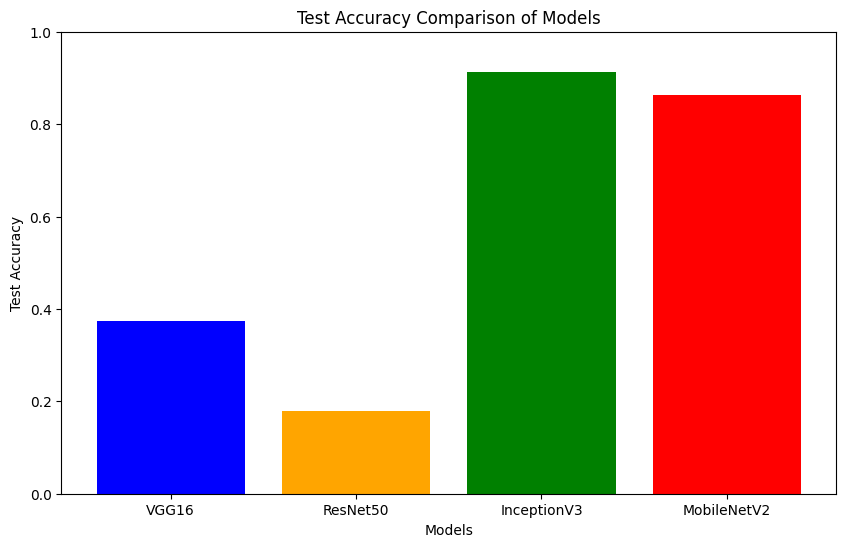

In [12]:
import matplotlib.pyplot as plt
from tabulate import tabulate

# Compare the test accuracy scores of the three models
models = ['VGG16', 'ResNet50', 'InceptionV3', 'MobileNetV2']
test_accuracies = [vgg16_test_acc, resnet50_test_acc, inceptionv3_test_acc, mobilenetv2_test_acc]

# Print the test accuracy scores in a table
table_data = list(zip(models, [f"{accuracy * 100:.2f}%" for accuracy in test_accuracies]))
table_headers = ["Model", "Test Accuracy"]

# Print table using tabulate
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

# Plot the test accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(models, test_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.title('Test Accuracy Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to better visualize differences
plt.show()

113/113 [==============================] - 3s 23ms/step


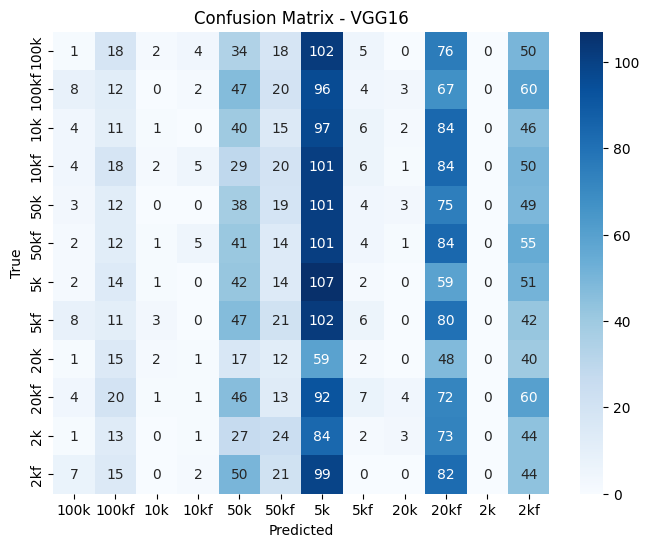

113/113 [==============================] - 3s 25ms/step


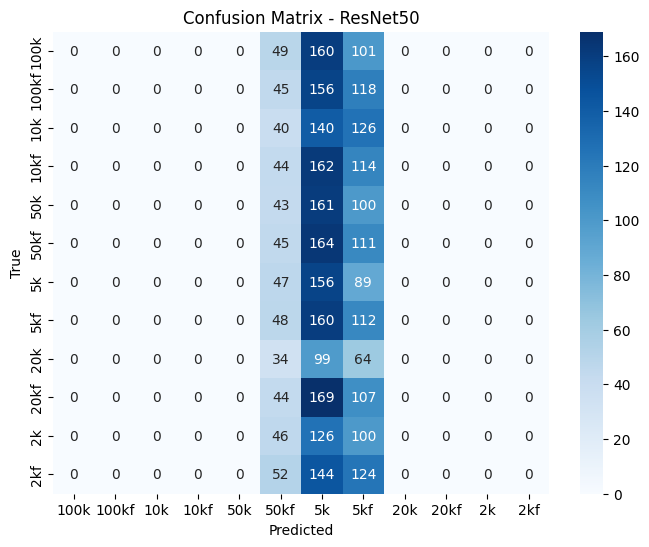

113/113 [==============================] - 5s 44ms/step


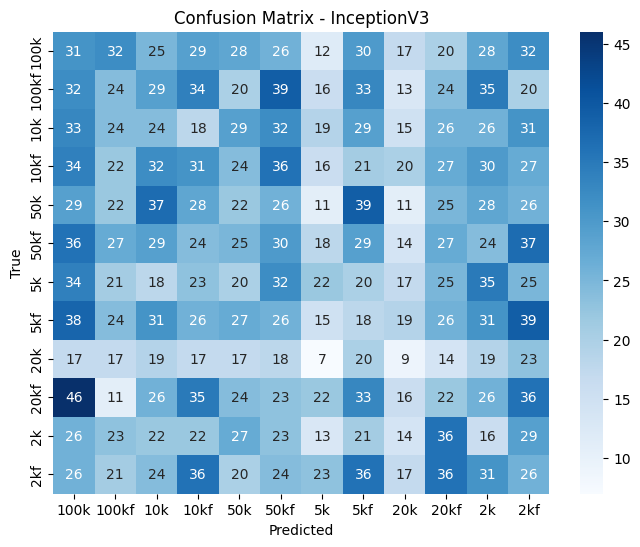

113/113 [==============================] - 3s 23ms/step


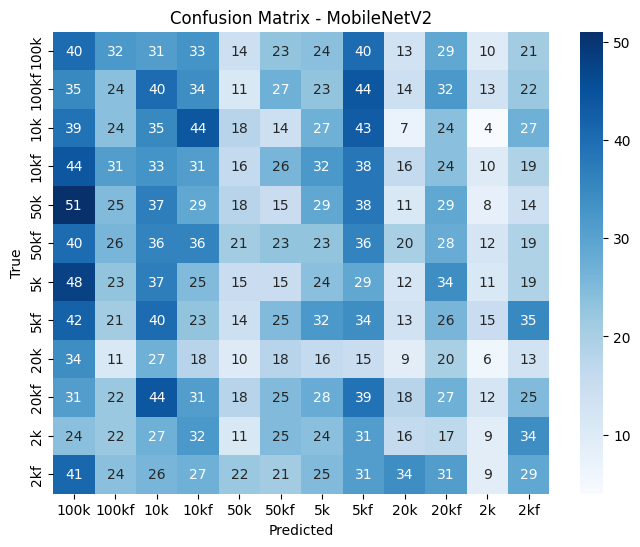

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_generator, class_labels, model_name):
    # Generate predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true classes
    true_classes = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Define class labels (replace with your actual class labels)
class_labels = ['100k', '100kf', '10k', '10kf', '50k', '50kf', '5k', '5kf', '20k', '20kf', '2k', '2kf']

# Plot confusion matrix for VGG16
plot_confusion_matrix(vgg16_model, vgg16_test_generator, class_labels, model_name='VGG16')

# Plot confusion matrix for ResNet50
plot_confusion_matrix(resnet50_model, resnet50_test_generator, class_labels, model_name='ResNet50')

# Plot confusion matrix for InceptionV3
plot_confusion_matrix(inceptionv3_model, inceptionv3_test_generator, class_labels, model_name='InceptionV3')

# Plot confusion matrix for MobileNetV2
plot_confusion_matrix(mobilenetv2_model, mobilenetv2_test_generator, class_labels, model_name='MobileNetV2')


In [14]:
from sklearn.metrics import classification_report
import numpy as np

# Function to get predictions and true labels
def get_predictions_and_labels(model, test_generator):
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    return predicted_labels, true_labels

# Function to print classification report
def print_classification_report(model_name, predicted_labels, true_labels):
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_labels, predicted_labels))

# Get predictions and true labels for VGG16
vgg16_predicted_labels, vgg16_true_labels = get_predictions_and_labels(vgg16_model, vgg16_test_generator)
print_classification_report("VGG16", vgg16_predicted_labels, vgg16_true_labels)

# Get predictions and true labels for ResNet50
resnet50_predicted_labels, resnet50_true_labels = get_predictions_and_labels(resnet50_model, resnet50_test_generator)
print_classification_report("ResNet50", resnet50_predicted_labels, resnet50_true_labels)

# Get predictions and true labels for InceptionV3
inceptionv3_predicted_labels, inceptionv3_true_labels = get_predictions_and_labels(inceptionv3_model, inceptionv3_test_generator)
print_classification_report("InceptionV3", inceptionv3_predicted_labels, inceptionv3_true_labels)

# Get predictions and true labels for MobileNetV2
mobilenetv2_predicted_labels, mobilenetv2_true_labels = get_predictions_and_labels(mobilenetv2_model, mobilenetv2_test_generator)
print_classification_report("MobileNetV2", mobilenetv2_predicted_labels, mobilenetv2_true_labels)

113/113 [==============================] - 3s 23ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.16      0.02      0.04       310
           1       0.09      0.05      0.07       319
           2       0.00      0.00      0.00       306
           3       0.14      0.01      0.02       320
           4       0.08      0.12      0.09       304
           5       0.08      0.05      0.06       320
           6       0.08      0.33      0.13       292
           7       0.04      0.01      0.01       320
           8       0.06      0.01      0.01       197
           9       0.09      0.25      0.13       320
          10       0.00      0.00      0.00       272
          11       0.09      0.17      0.12       320

    accuracy                           0.09      3600
   macro avg       0.08      0.08      0.06      3600
weighted avg       0.08      0.09      0.06      3600

  3/113 [..............................] - E

/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113/113 [==============================] - 3s 26ms/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       310
           1       0.00      0.00      0.00       319
           2       0.00      0.00      0.00       306
           3       0.00      0.00      0.00       320
           4       0.00      0.00      0.00       304
           5       0.07      0.11      0.08       320
           6       0.09      0.53      0.15       292
           7       0.09      0.35      0.14       320
           8       0.00      0.00      0.00       197
           9       0.00      0.00      0.00       320
          10       0.00      0.00      0.00       272
          11       0.00      0.00      0.00       320

    accuracy                           0.08      3600
   macro avg       0.02      0.08      0.03      3600
weighted avg       0.02      0.08      0.03      3600

  2/113 [..............................] 

/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dharsan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113/113 [==============================] - 5s 44ms/step
Classification Report for InceptionV3:
              precision    recall  f1-score   support

           0       0.10      0.12      0.11       310
           1       0.09      0.08      0.09       319
           2       0.09      0.09      0.09       306
           3       0.09      0.09      0.09       320
           4       0.08      0.08      0.08       304
           5       0.08      0.08      0.08       320
           6       0.11      0.08      0.09       292
           7       0.09      0.09      0.09       320
           8       0.06      0.06      0.06       197
           9       0.11      0.11      0.11       320
          10       0.07      0.09      0.08       272
          11       0.10      0.11      0.11       320

    accuracy                           0.09      3600
   macro avg       0.09      0.09      0.09      3600
weighted avg       0.09      0.09      0.09      3600

113/113 [=============================